In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from torch.autograd import Variable
import random
import torch.optim as optim
import pickle
import torch.utils.data
from torch.backends import cudnn
from scipy.sparse import csr_matrix
import math
import bottleneck as bn
import matplotlib.pyplot as plt
import time

# Dataset

In [2]:
inter = 5
u_implicit = torch.load('u_implicit_' + str(inter) + '.pt')

# split into train, val (It is already shuffled)
u_len = len(u_implicit)
u_train = u_implicit[:int(u_len*0.72), :]
u_val = u_implicit[int(u_len*0.72):int(u_len*0.8), :]
u_test = u_implicit[int(u_len*0.8):, :]

# train set
class traindset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, idx):
        return self.data[idx]
        
    def __len__(self):
        return np.shape(self.data)[0]
    
u_train_dset = traindset(u_train)
u_val_dset = traindset(u_val)
u_test_dset = traindset(u_test)

num_users = u_train.size()[0]
num_items = u_train.size()[1]

In [3]:
print(u_implicit.sum())
print(u_train.size())
print(u_val.size())
print(u_test.size())

tensor(575242.)
torch.Size([4340, 3533])
torch.Size([482, 3533])
torch.Size([1206, 3533])


# Eval

In [4]:
def NDCG(x_recon, x, k, seed):
    # delete seed items for eval
    mask = torch.ones(x.size()[1])
    mask[seed] = 0
    x = x[:, mask==True]
    x_recon = x_recon[:, mask==True]
    
    summ = 0
    topk_idx = torch.topk(x_recon, k, dim = 1)[1]
    mom = torch.FloatTensor(np.log2(np.arange(2,k+2))).cuda()
    ideal = torch.FloatTensor(np.ones(k)).cuda() / mom
    for u in range(len(x)):
        dcg = torch.sum(x[u, topk_idx[u]] / mom)
        idcg = torch.sum(ideal[:min(int(torch.sum(x[u, :]).cpu().tolist()), k)])
        summ += dcg / idcg
        
    return summ

# Model

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.latent_dim = latent_dim
        self.sm = nn.Softmax(dim = 0)
        
        #self.logpi = nn.Parameter(torch.randn(input_size, latent_dim)) #normal
        self.logpi = nn.Parameter(torch.ones(input_size, latent_dim)/self.input_size) #uniform
        
    def forward(self, x, T):
        g = torch.distributions.Gumbel(0, 1).sample((self.input_size, self.latent_dim)).cuda()
        y = self.sm((self.logpi + g) / T)
       
        return torch.matmul(x, y)

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_size):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim[-1], latent_dim[-2]),
            nn.Sigmoid(),
            nn.Linear(latent_dim[-2], output_size),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        recon_x = self.model(z)
        return recon_x

# Training

In [6]:
#hyper-parameters
num_present = 10 # k
latent_dim = [300, num_present]
T0 = 10
TB = 0.01
lrate = 0.002
epochs = 2000
use_cuda = torch.cuda.is_available()
batch_size = 128

#models
E = Encoder(num_items, num_present)
De = Decoder(latent_dim, num_items)
criterion = nn.MSELoss()

if use_cuda:
    E = E.cuda()
    De = De.cuda()

optim_E = optim.Adam(E.parameters(), lr=lrate)
optim_De = optim.Adam(De.parameters(), lr=lrate)

#data
train_loader = torch.utils.data.DataLoader(dataset = u_train_dset, batch_size = batch_size, shuffle = False)
val_loader = torch.utils.data.DataLoader(dataset = u_val_dset, batch_size = 3000, shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = u_test_dset, batch_size = 3000, shuffle = False)

#hist
hist_train = []
hist_val = []
hist_n10 = []
hist_n20 = []
hist_n50 = []
hist_n100 = []

In [7]:
for epoch in range(1, epochs+1):
    recont = 0
    T = T0*((TB/T0)**(epoch/epochs))
    
    E.train()
    De.train()
    for batch_idx, x in enumerate(train_loader):
        batch_size = x.size()[0]
        if use_cuda:
            x = x.cuda()

        ################## Reconstruction #########################
        optim_E.zero_grad()
        optim_De.zero_grad()
        
        z = E(x, T)
        x_recon = De(z)
        
        loss_recon = criterion(x_recon, x)
        recont += loss_recon
        loss_recon.backward()
        optim_E.step()
        optim_De.step()
        ####### print error
        
    if epoch % 50 == 0:
        hist_train.append(recont / len(train_loader))
        print('==>>> epoch: {}, T: {:.6f}, loss_train: {:.6f}'.format(epoch, T, recont / len(train_loader)))
        
        ####### evaluation
        E.eval()
        De.eval()
        with torch.no_grad():
            recont = 0
            n10, n20, n50, n100 = 0, 0, 0, 0
            for x in val_loader:
                batch_size = x.size()[0]
                if use_cuda:
                    x = x.cuda()

                z = E(x, T)
                x_recon = De(z)

                loss_recon = criterion(x_recon, x)

                recont += loss_recon
                seed = torch.max(E.logpi, dim = 0)[1]
                n10 += NDCG(x_recon, x, 10, seed)
                n20 += NDCG(x_recon, x, 20, seed)
                n50 += NDCG(x_recon, x, 50, seed)
                n100 += NDCG(x_recon, x, 100, seed)
            hist_val.append(recont/u_val.size()[0])
            hist_n10.append(n10 / u_val.size()[0])
            hist_n20.append(n20 / u_val.size()[0])
            hist_n50.append(n50 / u_val.size()[0])
            hist_n100.append(n100 / u_val.size()[0])
            print('==>>> epoch: {}, loss_val: {:.6f}'.format(epoch, recont / len(val_loader)))
            print('==>>> epoch: {}, n10: {:.6f}, n20: {:.6f}, n100; {:.6f}'.format(epoch, n10 / u_val.size()[0], n20 / u_val.size()[0], n100 / u_val.size()[0]))

print("===================Finished!===================")            

==>>> epoch: 50, T: 8.413951, loss_train: 0.021666
==>>> epoch: 50, loss_val: 0.023191
==>>> epoch: 50, n10: 0.428212, n20: 0.401452, n100; 0.367820
==>>> epoch: 100, T: 7.079458, loss_train: 0.021551
==>>> epoch: 100, loss_val: 0.023083
==>>> epoch: 100, n10: 0.431925, n20: 0.402572, n100; 0.370352
==>>> epoch: 150, T: 5.956621, loss_train: 0.021495
==>>> epoch: 150, loss_val: 0.023027
==>>> epoch: 150, n10: 0.434568, n20: 0.403742, n100; 0.371922
==>>> epoch: 200, T: 5.011872, loss_train: 0.021459
==>>> epoch: 200, loss_val: 0.022991
==>>> epoch: 200, n10: 0.436036, n20: 0.406010, n100; 0.373221
==>>> epoch: 250, T: 4.216965, loss_train: 0.021440
==>>> epoch: 250, loss_val: 0.022976
==>>> epoch: 250, n10: 0.427767, n20: 0.399441, n100; 0.369868
==>>> epoch: 300, T: 3.548134, loss_train: 0.021400
==>>> epoch: 300, loss_val: 0.022942
==>>> epoch: 300, n10: 0.432797, n20: 0.399285, n100; 0.371564
==>>> epoch: 350, T: 2.985383, loss_train: 0.020645
==>>> epoch: 350, loss_val: 0.022186
==

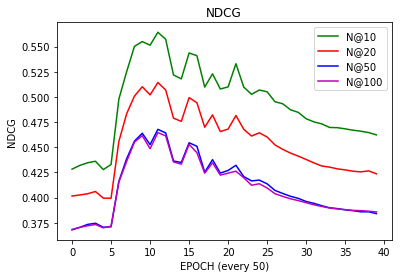

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.title("NDCG")
plt.xlabel("EPOCH (every 50)")
plt.ylabel("NDCG")
#plt.ylim(0, 600)
plt.plot(range(0, len(hist_n10)), hist_n10, 'g', label = "N@10")
plt.plot(range(0, len(hist_n20)), hist_n20, 'r', label = "N@20")
plt.plot(range(0, len(hist_n50)), hist_n50, 'b', label = "N@50")
plt.plot(range(0, len(hist_n100)), hist_n100, 'm', label = "N@100")
plt.legend()
plt.show()

# Retraining

In [9]:
# train set
class traindsetr(torch.utils.data.Dataset):
    def __init__(self, data, full):
        self.data = data
        self.full = full
        
    def __getitem__(self, idx):
        return self.data[idx], self.full[idx]
        
    def __len__(self):
        return np.shape(self.data)[0]

# recommend with seed item
def recommend(itemseed, num_present, hidden, e):   
    u_train_np = u_train.cpu().numpy()
    u_test_np = u_test.cpu().numpy()
    
    #model parameter
    latent_dim = [hidden, num_present]

    #training parameter
    lrate = 0.001
    epochs = e
    use_cuda = torch.cuda.is_available()
    batch_size = 256
    lamb = 0.0001

    #models
    De = Decoder(latent_dim, num_items)
    criterion = nn.MSELoss(reduction = 'none')

    if use_cuda:
        De = De.cuda()
        criterion = criterion.cuda()

    optim_De = optim.Adam(De.parameters(), lr=lrate)

    #data
    u_train_dset = traindsetr(u_train_np[:, itemseed], u_train_np)
    u_test_dset = traindsetr(u_test_np[:, itemseed], u_test_np)
    train_loader = torch.utils.data.DataLoader(dataset = u_train_dset, batch_size = batch_size, shuffle = True)
    test_loader = torch.utils.data.DataLoader(dataset = u_test_dset, batch_size = 3000, shuffle = True)
    
    #re-training
    for epoch in range(1, epochs+1):
        recont = 0
        
        De.train()
        for batch_idx, (x, y) in enumerate(train_loader):
            batch_size = x.size()[0]
            if use_cuda:
                x = x.cuda()
                y = y.cuda()

            ################## Reconstruction #########################
            optim_De.zero_grad()

            x_recon = De(x)

            loss_recon = torch.sum(criterion(x_recon, y))
            l2_reg = Variable(torch.FloatTensor(1), requires_grad=True).cuda()
            for W in De.parameters():
                l2_reg = l2_reg + W.norm(2)

            loss = loss_recon + l2_reg * lamb
            recont += loss_recon / batch_size
            loss.backward()
            optim_De.step()

    ####### test
    De.eval()
    with torch.no_grad():
        recont = 0
        n10, n20, n50, n100= 0,0,0,0

        for x, y in test_loader:
            batch_size = x.size()[0]
            if use_cuda:
                x = x.cuda()
                y = y.cuda()

            x_recon = De(x)

            loss_recon = torch.sum(criterion(x_recon, y))
            recont += loss_recon / batch_size

            n20 += NDCG(x_recon, y, 20,itemseed) 
            n10 += NDCG(x_recon, y, 10, itemseed) 
            n100 += NDCG(x_recon, y, 100, itemseed) 
            n50 += NDCG(x_recon, y, 50, itemseed)

        print("N@10: ",n10 / u_test.size()[0])
        print("N@20: ",n20 / u_test.size()[0])
        print("N@50: ",n50 / u_test.size()[0])
        print("N@100: ",n100 / u_test.size()[0])

    return None

In [12]:
recommend(torch.max(E.logpi, dim = 0)[1].cpu().tolist(), 10, 300, 150)

N@10:  tensor(0.4979, device='cuda:0')
N@20:  tensor(0.4524, device='cuda:0')
N@50:  tensor(0.4133, device='cuda:0')
N@100:  tensor(0.4183, device='cuda:0')
